In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [119]:
def n_day_regression(n,data):
  lr=LinearRegression()
  X=list(range(n))
  X=np.array(X)

  _varname_ = f'{n}_reg'
  data[_varname_]=np.nan

  for i in range(n-1,len(data)):
    y=[]
    for j in range(0,n):
      y.append(data["Close"][i-j])
    y=y[::-1]
    y=np.array(y)
    X=X.reshape(X.shape[0],1)
    y=y.reshape(y.shape[0],1)
    lr.fit(X,y)
    coef=lr.coef_[0][0]
    data.loc[i,_varname_]=coef

  return data

In [120]:
def local_maxima_minima(data,n=5):

  data["local_min"]=np.nan
  data["local_max"]=np.nan
  print(len(data))
  for i in range(n,len(data)-n):
    l = data["Close"][i-n:i+n]
    if data["Close"][i]==min(l):
      data.loc[i,"local_min"]=1
      data.loc[i,"local_max"]=0
    elif data["Close"][i]==max(l):

      data.loc[i,"local_max"]=1
      data.loc[i,"local_min"]=0
    else:
      data.loc[i,"local_max"]=0
      data.loc[i,"local_min"]=0

  return data

In [121]:
def test_data(filename):
    data = pd.read_csv(f"./{filename}.csv")
    data['Normalised_value'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    
    data['Normalised_value'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    
    data=local_maxima_minima(data)
    local_minima_indices = np.where(data['local_min'] > 0)[0]
    local_maxima_indices = np.where(data['local_max'] > 0)[0]
    
    data=n_day_regression(3,data)
    data=n_day_regression(5,data)
    data=n_day_regression(10,data)
    data=n_day_regression(20,data)

    data = data.dropna().reset_index(drop = True)
    tst = data[['Volume', 'Normalised_value', '3_reg', '5_reg', '10_reg', '20_reg']]
    tst = scaler.transform(tst)

    return data,tst

In [122]:
scaler=MinMaxScaler()
scaled_data = pd.read_csv('merged_data.csv')

In [123]:
#creating train and test set
scaled_data = scaled_data.sample(frac = 1)
scaled_data.head()
y = scaled_data['target']
X = scaled_data.drop('target', axis = 1)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X)

[[6.59170389e-02 7.19361760e-01 6.30972158e-01 6.11277936e-01
  3.67932549e-01 4.36141804e-01]
 [4.52139098e-05 1.60457179e-01 5.61465878e-01 5.41584771e-01
  3.79137332e-01 4.59981854e-01]
 [1.42280114e-03 1.20019674e-01 6.08844441e-01 6.03233967e-01
  3.66673225e-01 3.99966688e-01]
 ...
 [4.67454704e-02 1.42815463e-01 6.13861386e-01 6.03361360e-01
  3.72603231e-01 4.48764862e-01]
 [3.08815093e-03 5.13698091e-01 6.09010565e-01 5.98074543e-01
  3.77244445e-01 4.55966465e-01]
 [3.64348049e-03 6.64445465e-01 6.20805369e-01 6.08793769e-01
  3.76006788e-01 4.61346054e-01]]


In [124]:
model = lr(C=10,class_weight=None,multi_class='ovr',penalty= 'l1',solver='liblinear', tol= 0.0001)
#model = lr()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model test accuracy (in %):", acc*100)
y_chk = model.predict(X_train)
acc = accuracy_score(y_train, y_chk)
print("Logistic Regression model train accuracy (in %):", acc*100)

Logistic Regression model test accuracy (in %): 98.19711538461539
Logistic Regression model train accuracy (in %): 98.0617564496725


C:\Users\nanda\OneDrive\Desktop\Stock_data\env\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [125]:
data,tst=test_data("INE371A01025")
probs = model.predict_proba(tst)[:, 1]
print(probs)

1238
[0.95660516 0.40145939 0.00669836 ... 0.31130081 0.80906921 0.99187494]


In [126]:
y_out = np.where(probs <= 0.03, 0, 1)
y_actual = np.array(1 - data.loc[:, 'local_min'])

Text(0.5, 1.0, 'Confusion matrix for local minima with threshold 0.03(Potential Buying Points)')

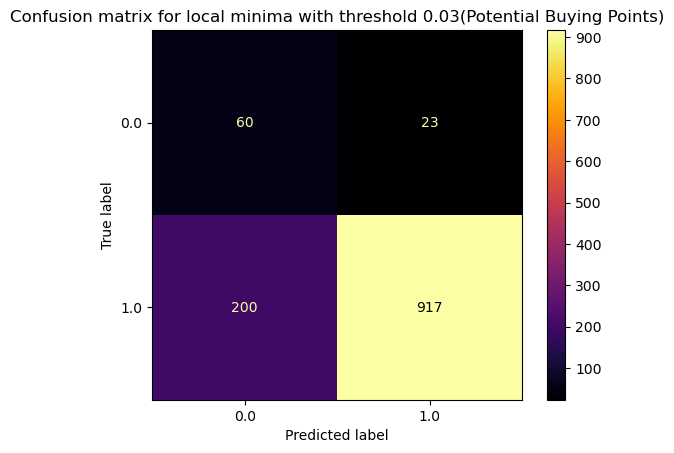

In [127]:
cm = ConfusionMatrixDisplay.from_predictions(y_true=y_actual, 
                                        y_pred=y_out, cmap = 'inferno')
cm.ax_.set_title('Confusion matrix for local minima with threshold 0.03(Potential Buying Points)')

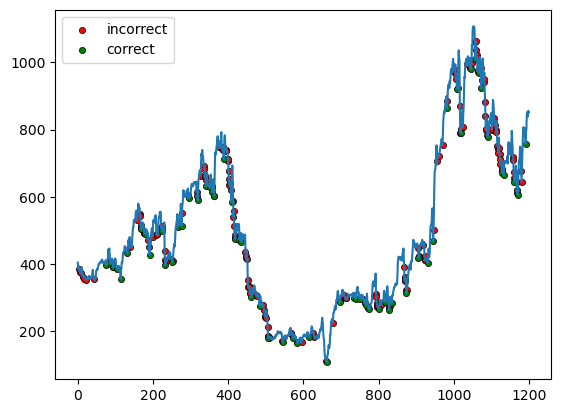

In [130]:
plt.plot(range(len(data)), data.loc[:, 'Close'])
good_x = []
good_y = []
bad_x = []
bad_y = []
for i in range(len(y_out)):
    if(y_out[i] == 0 and y_actual[i] == 0):
        good_x.append(i)
        good_y.append(data.loc[i, 'Close'])
    if(y_out[i] == 0 and y_actual[i] == 1):
        bad_x.append(i)
        bad_y.append(data.loc[i, 'Close'])

plt.scatter(bad_x, bad_y, c = 'red', s = 20, edgecolor = 'k', linewidths = 0.5, label = 'incorrect')
plt.scatter(good_x, good_y, c = 'green', s = 20, edgecolor = 'k', linewidths = 0.5, label = 'correct')
plt.legend()

In [131]:
y_out = np.where(probs >= 0.90, 1, 0)
y_actual = np.array(data.loc[:, 'local_max'])

Text(0.5, 1.0, 'Confusion matrix for local maxima with threshold 0.9(Potential Selling Points)')

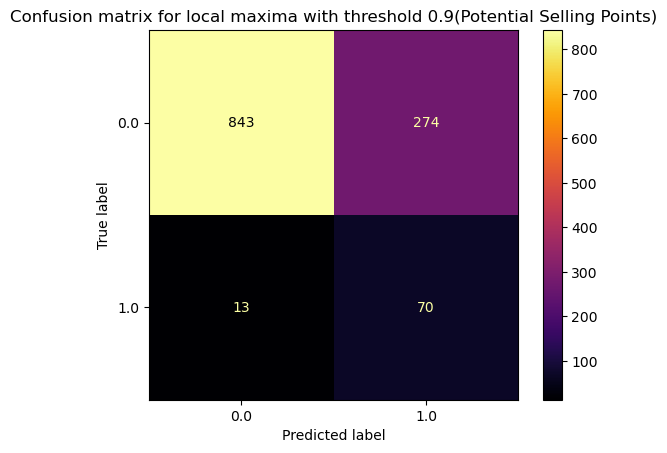

In [132]:
cm = ConfusionMatrixDisplay.from_predictions(y_true=y_actual, 
                                        y_pred=y_out, cmap = 'inferno')
cm.ax_.set_title('Confusion matrix for local maxima with threshold 0.9(Potential Selling Points)')

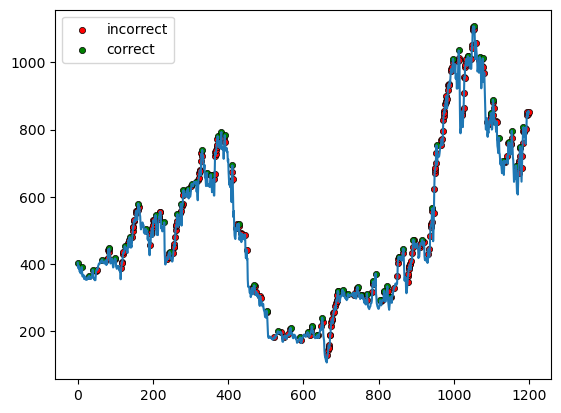

In [133]:
plt.plot(range(len(data)), data.loc[:, 'Close'])
good_x = []
good_y = []
bad_x = []
bad_y = []
for i in range(len(y_out)):
    if(y_out[i] == 1 and y_actual[i] == 1):
        good_x.append(i)
        good_y.append(data.loc[i, 'Close'])
    if(y_out[i] == 1 and y_actual[i] == 0):
        bad_x.append(i)
        bad_y.append(data.loc[i, 'Close'])

plt.scatter(bad_x, bad_y, c = 'red', s = 20, edgecolor = 'k', linewidths = 0.5, label = 'incorrect')
plt.scatter(good_x, good_y, c = 'green', s = 20, edgecolor = 'k', linewidths = 0.5, label = 'correct')
plt.legend()